# Import dependencies

In [72]:
# dependency definition
SCOPETYPE = 'OPENADC'
PLATFORM = 'OpenTitan'  # 'CWLITEARM'
CRYPTO_TARGET = "NONE"

#Capture Traces
import chipwhisperer as cw
from tqdm import tnrange
import numpy as np
import time

# Serial communication
import serial

# Plotting
#import holoviews as hv
#import matplotlib.pyplot as plt

# Subprocess
import subprocess
from subprocess import Popen, PIPE, check_output

from pathlib import Path

# Define Colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    CORG = '\x1b[6;39;43m'
    CLiBL = '\x1b[0;30;44m'
    CBLACK  = '\33[60m'

# Connect to scope and target

In [2]:
# Connect to scope and target
# Connect to serial via pipe
%run "Helper_Scripts/Setup_OpenTitan.ipynb"
connectSerial(target, 115200)
#scope.adc.samples = 2000
print("\n")
scope.default_setup()
scope.adc.samples = 5000
scope.adc.offset = 0
scope.gain.db = 35
#print(scope.io.tio4) # high_z
#print(scope.io.pdic) # high
#print(scope.trigger.triggers) #tio4

Serial baud rate = 38400
Serial<id=0x7fc40444e210, open=True>(port='/dev/ttyUSB1', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=250, xonxoff=False, rtscts=False, dsrdtr=False)




## Build and Flash SW to Arty S7

In [3]:
# Build and Flash SW to Arty S7
flash_file = 'build_basic.sh'
file_path = '/home/ms/opentitan'
# Reset Target and Flash SW
#reset_target(scope)
#time.sleep(0.025)
#flash_software(flash_file, file_path)

# Capture Traces

In [ ]:
ktp = cw.ktp.Basic()
key, pt = ktp.new_pair()

end_cmd = '\n'
message = 'h0px3'

text = (message + end_cmd)
text_enc = text.encode()
target.flush()
                
ct = None
M = 1
for i in tnrange(M, desc='Capturing UART'):
    #rt = target.simpleserial_read('r', 32, end='\n', timeout=250, ack=False)
    c = target.write(text_enc)
    target.flush()
    # 100ms dely
    time.sleep(5.0)
    ct = target.read(128) #, timeout='250')
    if ct:
        print("ct: " + ct.decode("utf-8") )
    #target.in_waiting()
    #dt = target.simpleserial_read('r', 32)
    #if dt:
        #print("dt: " + dt.decode("utf-8") )
    #wt = target.write(text.encode())
    #rd = target.read_usb(target_ser, target_ser_bd, 64) # read 64 bytes
    #if rt:
        #print("rd: " + rt.decode("utf-8") )


In [ ]:
#capture_ot(scope, target, plaintext=None, key=None, ack=False)

In [ ]:
# Capture traces
ktp = cw.ktp.Basic()
#target = cw.target(scope)


traces = []
#if PLATFORM == "CWNANO":
    #N = 1500
#else:
N = 1000  # Number of traces


for i in tnrange(N, desc='Capturing traces'):
    key, text = ktp.next()
    
    trace = cw.capture_trace(scope, target, text, key, None)
    #trace = cw.capture_ot(scope, target, None, None, None)
    if trace is None:
        continue
    traces.append(trace)

# Plot traces

In [ ]:
# Plot traces
%matplotlib notebook
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pylab as plt


# Turn interactive plotting off
#plt.ioff()
    
    
# Simple trace
scope.arm()
scope.adc.samples = 3000 # 2000 # [-6,]
scope.gain.db = 50       # [-6.5, 56]

gain = range(25, 25, 5)
db=25
#print(gain)

project = 'for_loop10'
configuration = 'INA210'
folder = "/home/ms/chipwhisperer/traces/8mhz/" + configuration + "/vref_165/"

#for idx in range(len(gain)):

#for db in gain:
print(db)
#print(gain[idx])

scope.gain.db = int(db)
#print(scope.gain.db)
db_str = str(round(scope.gain.db))
#print(db_str)
filename = project + '_' + db_str + 'db'
time.sleep(0.5)

scope.arm()
reset_target(scope)
time.sleep(0.01)
flash_software(flash_file, file_path)
time.sleep(0.01)
resp = scope.capture()
if resp:
    print('Timeout happened during acquisition')
trace = scope.get_last_trace()

figure = plt.figure(num=db, figsize=(8, 8)) #, dpi=100)
plt.title(label=filename)
plt.plot(trace)
#plt.show()

#time.sleep(1)
#plt.ylabel('some numbers')
save_picture(folder, project, filename, figure)

#plt.clf()
#plt.cla()
#plt.close(figure)

plt.show()

In [7]:
def cap_pass_trace(pass_guess):
    ret = bytes()
    resp = ""
    reset_target(scope)
    time.sleep(0.01)
    flash_software(flash_file, file_path)
    #time.sleep(1)
    
    num_char = target.in_waiting()
    while num_char > 0:
        ret += target.read() # num_char, 10
        time.sleep(0.01)
        num_char = target.in_waiting()

    scope.arm()
    target.write(pass_guess.encode())
    time.sleep(0.01)
    resp = scope.capture()
    if resp:
        print('Timeout happened during acquisition')

    trace = scope.get_last_trace()
    return trace

In [83]:
trace_correct = []
trace_false = []

scope.adc.samples = 4000 # def: 5000
#scope.adc.decimate = 1
#scope.adc.offset = 250
scope.gain.db = 30

config = ['JP3_left', 'JP3_right', 'JP4_left', 'JP4_right', 'INA210']
projects = ['for_loop5', 'for_loop10', 'basicpwcheck']

project = projects[2]
print(bcolors.CLiBL + bcolors.CBLACK + project + bcolors.ENDC)
configuration = config[4] # 'JP3_right' #INA210'
print(bcolors.CORG + bcolors.CBLACK + configuration + bcolors.ENDC)

vref = "vref_165"
folder = "/home/ms/chipwhisperer/traces/8mhz/" + configuration + "/JP4/" + vref + "/"
db_str = str(round(scope.gain.db))
#filename = project + '_' + configuration + '_' + db_str + 'db'
filename = project + '_' + db_str + 'db'

t_correct = "h0px3\n"
t_false = "h0\n"
trace_correct = cap_pass_trace((t_correct))
time.sleep(10)
trace_false   = cap_pass_trace((t_false))

print("tracing done\n")
from IPython.display import Javascript
#next_cell = Javascript('IPython.notebook.get_next_cell()'
#display(Javascript('IPython.notebook.execute_cell_below()'))
(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1)'))

basicpwcheck
INA210
tracing done



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


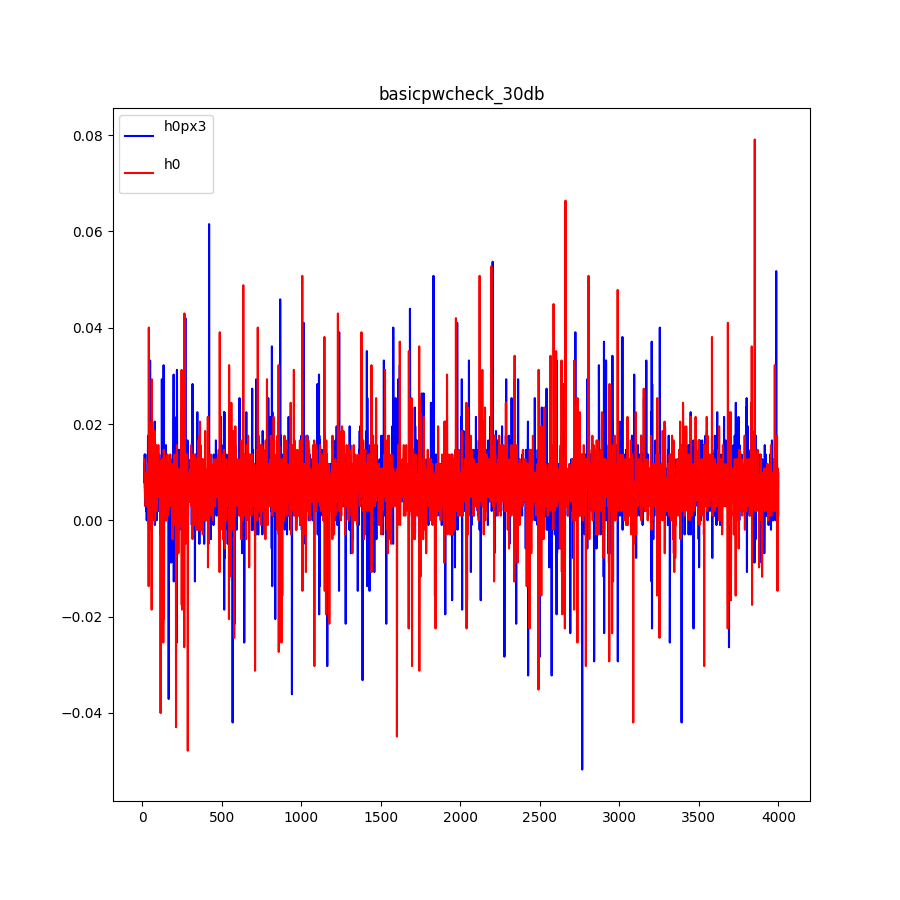

/home/ms/.local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


Saved trace to: /home/ms/chipwhisperer/traces/8mhz/INA210/JP4/vref_165/basicpwcheck/basicpwcheck_30db_03.png



In [84]:
%matplotlib notebook
import matplotlib.pylab as plt

data = []
data2 = []

figure = plt.figure(num=None, figsize=(9, 9)) #, dpi=100) # (int(db_str) +1)
plt.title(label=filename)
#t = range(scope.adc.samples)
#t = np.linspace(10, 1, scope.adc.samples)
t = range(12, scope.adc.samples, 1)
#print(t)
data = [(trace_correct[i]) for i in t]
data2 = [(trace_false[i]) for i in t]

#plt.plot(trace_correct, 'b')
#plt.plot(trace_false, 'r')
#plt.plot(t, data, 'b')
#save_picture(folder, project, filename, figure)
ax = figure.add_subplot(111)
#ax.plot(trace)
#ax.plot(trace_false, '-r', label=t_false)
#ax.plot(trace_correct, '-b', label=t_correct)
#plt.ylim(-0.12, 0.12)
#plt.xlim(10, scope.adc.samples)
#ax.autoscale(enable=True)
#mmax = max(trace_correct)
#mmin = min(trace_correct)
#plt.ylim(mmin, mmax)
#plt.xlim(0, scope.adc.samples)

#data_cor_red = reject_outliers_2(trace_correct, m=20.0)
#ax.plot(trace_false, '-r', label=t_false)
ax.plot(t, data, '-b', label=t_correct)
ax.plot(t, data2, '-r', label=t_false)
plt.legend(loc="upper left")

save_picture(folder, project, filename, figure)
#plt.show()

# Filter and save data

savgol_filter


<IPython.core.display.Javascript object>


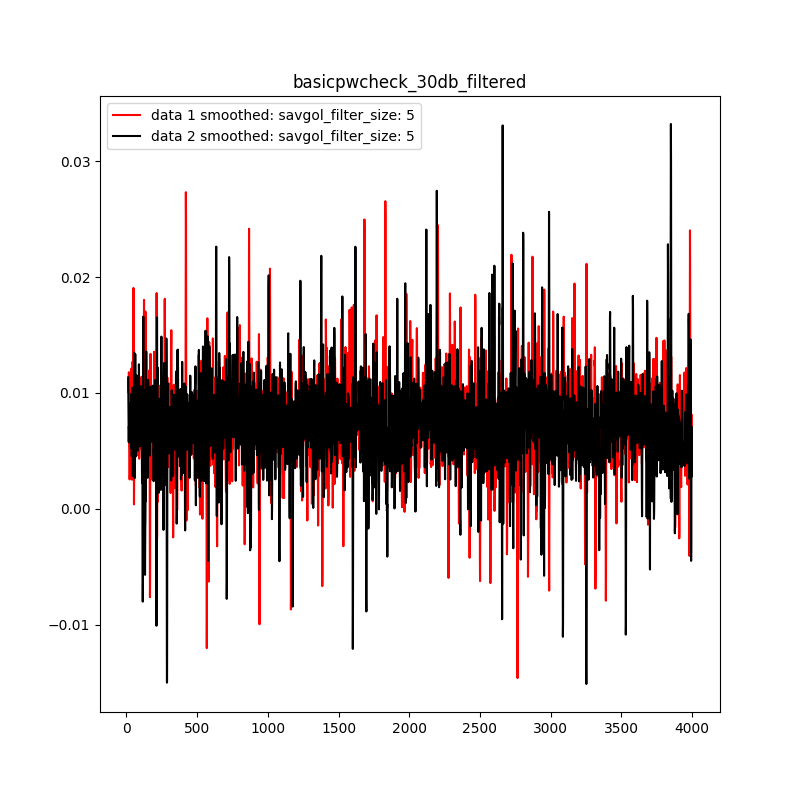

Saved trace to: /home/ms/chipwhisperer/traces/8mhz/INA210/JP4/vref_165/basicpwcheck/basicpwcheck_30db_filtered_03.png



'ax = figure.add_subplot(212)\nax.plot(t, data, \'-b\', label="data 1")\n#label1 = str("data 1 smoothed: " + this_func_name + "_size: " + str(sz))\n#ax.plot(t, y_mean1, \'-b\', label=label1)\n\nthis_func_name = savgol_filter.__name__\nlabel2 = str("data 1 smoothed: " + this_func_name + "_size: " + str(sz))\nax.plot(t, y_s1, \'-r\', label=label2)\nthis_func_name = gaussian_filter1d.__name__\nlabel3 = str("data 1 smoothed: " + this_func_name + "_size: " + str(gauss_kernel))\nax.plot(t, y_gauss1, \'-c\', label=label3)\nplt.legend(loc="upper left")\nfigure.show()'

In [85]:
import numpy as np
from pylab import *
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import *
from scipy.ndimage import *

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='full')
    return y_smooth

#project = 'for_loop5'
#configuration = 'JP4_right' #INA210'
#vref = "JP3_left" # vref_165"
#folder = "/home/ms/chipwhisperer/traces/8mhz/" + configuration + "/" #+ vref + "/"
#db_str = str(round(scope.gain.db))
#filename = project + '_' + configuration + '_' + db_str + 'db'
filename = project + '_' + db_str + 'db' + '_filtered'

sz = 5
gauss_kernel = 1.9

y_mean1 = uniform_filter1d(data, size=sz)
y_mean2 = uniform_filter1d(data2, size=sz)
y_median1 = median_filter(data, size=sz) # size should be odd
y_median2 = median_filter(data2, size=sz) # size should be odd
y_gauss1 = gaussian_filter1d(data, gauss_kernel)
y_gauss2 = gaussian_filter1d(data2, gauss_kernel)
y_s1 = savgol_filter(data, 11, sz, mode='nearest') # window size 51, polynomial order 3
y_s2 = savgol_filter(data2, 11, sz, mode='nearest') # window size 51, polynomial order 3
this_func_name = savgol_filter.__name__ # uniform_filter1d.__name__ 
print(this_func_name)

figure = plt.figure(num=None,figsize=(8, 8)) #, dpi=100) # num=(int(db_str) +2)
plt.title(label=filename)

#ax = figure.add_subplot(211)
ax = figure.add_subplot(111)
#ax.plot(t, data, '-g', label="data 1")
label1 = str("data 1 smoothed: " + this_func_name + "_size: " + str(sz))
ax.plot(t, y_s1, '-r', label=label1)
label2 = str("data 2 smoothed: " + this_func_name + "_size: " + str(sz))
ax.plot(t, y_s2, '-k', label=label2)

#label1 = str("data 1 smoothed: " + this_func_name + "_size: " + str(gauss_kernel))
#ax.plot(t, y_gauss1, '-r', label=label1)
#label2 = str("data 2 smoothed: " + this_func_name + "_size: " + str(gauss_kernel))
#ax.plot(t, y_gauss2, '-k', label=label2)

#smooth_sz = 5
#label1 = str("data 1 smoothed: " + "convolution" + "_size: " + str(smooth_sz))
#ax.plot(t, smooth(data,smooth_sz), 'k-', label=label1) #  lw=2
#label2 = str("data 2 smoothed: " + "convolution" + "_size: " + str(smooth_sz))
#ax.plot(t, smooth(data2,smooth_sz), 'm-', label=label2) # lw=2

plt.legend(loc="upper left")
figure.show()

save_picture(folder, project, filename, figure)

"""ax = figure.add_subplot(212)
ax.plot(t, data, '-b', label="data 1")
#label1 = str("data 1 smoothed: " + this_func_name + "_size: " + str(sz))
#ax.plot(t, y_mean1, '-b', label=label1)

this_func_name = savgol_filter.__name__
label2 = str("data 1 smoothed: " + this_func_name + "_size: " + str(sz))
ax.plot(t, y_s1, '-r', label=label2)
this_func_name = gaussian_filter1d.__name__
label3 = str("data 1 smoothed: " + this_func_name + "_size: " + str(gauss_kernel))
ax.plot(t, y_gauss1, '-c', label=label3)
plt.legend(loc="upper left")
figure.show()"""

# cleanup the connection to the target and scope

In [ ]:
scope.dis()
target.dis()

# Test

In [ ]:
#scope.adc.samples = 5000
#scope.adc.decimate = 1
#scope.adc.offset = 250
scope.gain.db = 30

END = "\n"
t_correct = "h0"
t_false = "h"
trace_correct = cap_pass_trace((t_correct + END))
time.sleep(1.5)
trace_false   = cap_pass_trace((t_false + END))
print("tracing done\n")

In [ ]:
mkdir -p basic_passwdcheck/JP3 & mkdir -p basic_passwdcheck/JP4

In [ ]:
%%bash
cd ../traces3/
mkdir -p for_loop5 & mkdir -p for_loop10

In [ ]:
#print(trace_correct)
#print(len(trace_correct))
#points = [(0.1*i, np.sin(0.1*i)) for i in range(100)]
#print(points)

t = range(2000) # np.linspace(0, 1, 1000)
#print(t)
data = [(trace_correct[i]) for i in t]
#print(trace_correct[1])
#print(data)

In [ ]:
from holoviews import plotting

hv.save(overlay, '/home/ms/chipwhisperer/traces2/basic_passwdcheck/for_5/test.png')

In [ ]:
#print("Save file to %s" % file)
          
           
#fig = hv.render(overlay, backend='matplotlib')
#fig.opts(width=600, height=600)
#fig.dpi = 100
#fig.figsize = [600, 600]
#print('Figure: ', fig)
#print('Figure dpi: ', fig.dpi)
#print('Figure figsize: ', fig.figsize)
#print(type(fig))
#fig.set_size_inches(6.5, 6.5)
#fig.savefig(file, dpi=400)
#print("saved")
#overlay

In [ ]:
#import numpy as np
#import holoviews as hv
hv.extension('bokeh')
t = range(2000)
#t = np.linspace(0, 1, 1000)
#data = [(trace_correct[i]) for i in t]
#t2 = [(i-12) for i in t]
#print(t2)
#data2 = [(trace_false[i]) for i in t2]
jumper = "for_5" # "JP3"
measurement = jumper + '_' + "ina214" # _right"
gain = 'gain = '+ str(round(scope.gain.db))
title = measurement + '_' + gain

curve1 = [hv.Curve(trace_correct, label=(t_correct + ' ')).opts(line_color='red', height=600, width=600)]
curve2 = [hv.Curve(trace_false, label=(t_false + ' .')).opts(line_color='blue', height=600, width=600)]
#curve1 = [hv.Curve(data, label='trace correct').opts(line_color='red')]
#curve2 = [hv.Curve(data2, label='trace false').opts(line_color='blue')]
#overlay = hv.Overlay(curve1 + curve2, label=title).opts(height=600, width=600)
overlay = hv.Overlay(curve1, label=title)# .opts(height=600, width=600)
overlay

In [ ]:
# Define zoom function
def zoom_factory(ax,base_scale = 2.):
    def zoom_fun(event):
        # get the current x and y limits
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()
        cur_xrange = (cur_xlim[1] - cur_xlim[0])*.5
        cur_yrange = (cur_ylim[1] - cur_ylim[0])*.5
        xdata = event.xdata # get event x location
        ydata = event.ydata # get event y location
        if (event.button) == 'up':
            # deal with zoom in
            scale_factor = 1/base_scale
        elif (event.button) == 'down':
            # deal with zoom out
            scale_factor = base_scale
        else:
            # deal with something that should never happen
            scale_factor = 1
            print (event.button)
        # set new limits
        ax.set_xlim([xdata - cur_xrange*scale_factor,
                     xdata + cur_xrange*scale_factor])
        ax.set_ylim([ydata - cur_yrange*scale_factor,
                     ydata + cur_yrange*scale_factor])
        plt.draw() # force re-draw

    fig = ax.get_figure() # get the figure of interest
    # attach the call back
    fig.canvas.mpl_connect('scroll_event',zoom_fun)

    #return the function
    return zoom_fun
#scale = 1.5
#f = zoom_factory(ax,base_scale = scale)

In [ ]:
#max(trace_correct)
#min(trace_correct)
def reject_outliers_2(data, m=2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d / (mdev if mdev else 1.)
    return data[s < m]

def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [76]:
#reset_target(scope)
pass_guess = "h0px3\n"
target.write(pass_guess.encode())

# Trigger Test

In [ ]:
# Simple trace
scope.arm()
scope.adc.samples = 4000 # 2000 # [-6,]
scope.gain.db = 25       # [-6.5, 56]

pins = ['JP3_left', 'JP3_right', 'JP4_left', 'JP4_right']
#print(pins[0])

project = 'basicpwcheck'
configuration = pins[1]
folder = "/home/ms/chipwhisperer/traces/30mhz/" + configuration + "/"

db_str = str(round(scope.gain.db))
#print(db_str)
filename = project + '_' + db_str + 'db'

# Trace 1
reset_target(scope)
time.sleep(0.01)
flash_software(flash_file, file_path)
time.sleep(4)
resp = scope.capture()
if resp:
    print('Timeout happened during acquisition')
trace1 = scope.get_last_trace()

# Trace 2
scope.arm()
scope.adc.samples = 4000 # 2000 # [-6,]
scope.gain.db = 30       # [-6.5, 56]

# Trace 2
time.sleep(0.01)
reset_target(scope)
time.sleep(0.01)
flash_software(flash_file, file_path)
time.sleep(4)
resp = scope.capture()
if resp:
    print('Timeout happened during acquisition')
trace2 = scope.get_last_trace()

t = range(0, scope.adc.samples, 1)
data = [(trace1[i]) for i in t]
data2 = [(trace2[i]) for i in t]

figure = plt.figure(num=(int(db_str) +1), figsize=(8, 8)) #, dpi=100)
plt.title(label=filename)
#t = range(scope.adc.samples)
#t = np.linspace(10, 1, scope.adc.samples)

ax = figure.add_subplot(111)
ax.plot(t, data, '-b', label=t_correct)
ax.plot(t, data2, '-r', label=t_false)
plt.legend(loc="upper left")


save_picture(folder, project, filename, figure)
plt.show()

In [ ]:
pw = "h0px3\n"
target.write(pw.encode())